In [14]:
### Importing Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
import statsmodels.graphics.tsaplots as tplots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime, time

In [38]:
### Reading Dataset
data = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
data

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


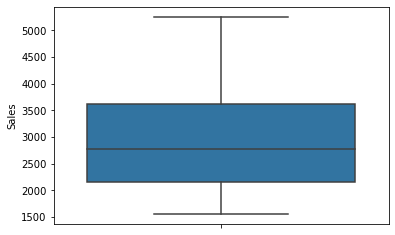

In [4]:
sns.boxplot('Sales', data=data, orient='v')

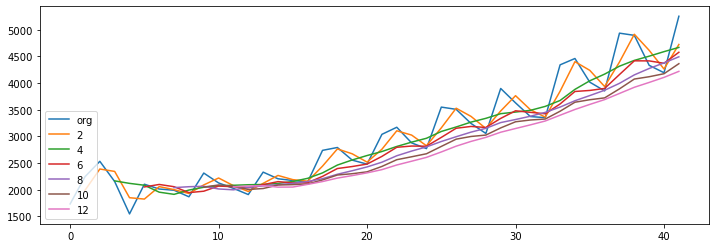

In [5]:
plt.figure(figsize=(12, 4))
data.Sales.plot(label = 'org')
for i in range(2, 14, 2):
    data['Sales'].rolling(i).mean().plot(label=str(i))
    plt.legend(loc=3)

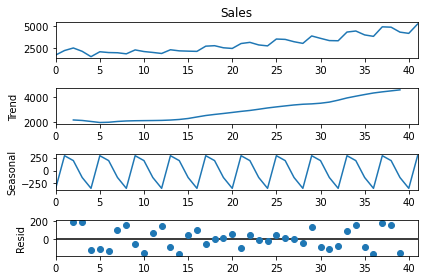

In [7]:
decom_ts_add = seasonal_decompose(data.Sales, period=4)
decom_ts_add.plot()
plt.show()

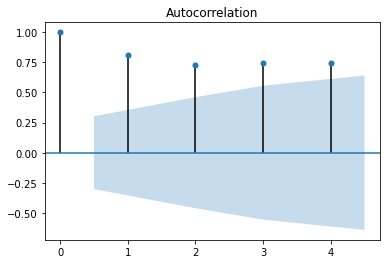

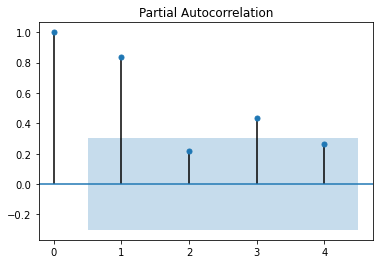

In [8]:
tplots.plot_acf(data.Sales, lags=4)
tplots.plot_pacf(data.Sales, lags=4)
plt.show()

In [10]:
### Splitting Train and Test Data
train = data.head(32)
test = data.tail(10)

In [9]:
### Function for MAPE
def mape(pred, org):
    x = np.abs((pred-org)/org)*100
    return np.mean(x)

#### Simple Exponential Smoothing Model

In [12]:
ses_model = SimpleExpSmoothing(train['Sales']).fit(smoothing_level=0.1)
pred_ses = ses_model.predict(start = test.index[0], end=test.index[-1])
ses_mape = mape(pred_ses, test.Sales)
ses_mape

29.74699061372714

#### Holt Method

In [18]:
holt_model = Holt(train['Sales']).fit(smoothing_level = 0.2, smoothing_slope = 0.1)
pred_holt = holt_model.predict(start = test.index[0], end=test.index[-1])
holt_mape = mape(pred_holt, test.Sales)
holt_mape


10.089601708349338

#### Holts Winter Exponential smoothing with additive seasonality and additive trend

In [22]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [23]:
warnings.simplefilter('ignore', ConvergenceWarning)
holt_add_add_model = ExponentialSmoothing(train['Sales'], seasonal='add', trend = 'add', seasonal_periods=4).fit()
pred_holt_add_add = holt_add_add_model.predict(start = test.index[0], end=test.index[-1])
holt_add_add_mape = mape(pred_holt_add_add, test.Sales)
holt_add_add_mape

10.717857886913109

#### Holts Winter Exponential smoothing with multiplicative seasonality and additive trend

In [32]:
holt_mul_add_model = ExponentialSmoothing(train['Sales'], seasonal='mul', trend='add', seasonal_periods=4).fit()
pred_holt_mul_add = holt_mul_add_model.predict(start = test.index[0], end=test.index[-1])
holt_mul_add_mape = mape(pred_holt_mul_add, test.Sales)
holt_mul_add_mape

11.047357483358835

#### Holts Winter Exponential smoothing with multiplicative seasonality and multiplicative trend

In [28]:
holt_mul_mul_model = ExponentialSmoothing(train['Sales'], seasonal='mul', trend='mul', seasonal_periods=4).fit()
pred_holt_mul_mul = holt_mul_add_model.predict(start = test.index[0], end=test.index[-1])
holt_mul_mul_mape = mape(pred_holt_mul_add, test.Sales)
holt_mul_mul_mape

9.589403338050804

In [34]:
acc_data = {'Model': pd.Series(['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5']), 'MAPE_Values': pd.Series([ses_mape, holt_mape, holt_add_add_mape, holt_mul_add_mape, holt_mul_mul_mape])}
acc_df = pd.DataFrame(acc_data).sort_values(by='MAPE_Values')
acc_df

,Model,MAPE_Values
4,Model_5,9.589403
1,Model_2,10.089602
2,Model_3,10.717858
3,Model_4,11.047357
0,Model_1,29.746991


#### By above scores we got to know that Holts Winter Exponential smoothing with multiplicative seasonality and multiplicative trend is the best model

#### Final Model Building with combining Train and Test data

In [36]:
holt_mul_mul_model_final = ExponentialSmoothing(data['Sales'], seasonal='mul', trend='mul', seasonal_periods=4).fit()

In [40]:
holt_mul_mul_model_final.forecast(8)

42    5237.773450
43    4776.351956
44    4545.289716
45    5776.443378
46    5748.237522
47    5241.846712
48    4988.265557
49    6339.405262
dtype: float64